In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [8]:
# Load the data

muc_2008 = "./munich2008.csv"
muc_2009 = "./munich2009.csv"
muc_2010 = "./munich2010.csv"
muc_2011 = "./munich2011.csv"
muc_2012 = "./munich2012.csv"
muc_2013 = "./munich2013.csv"
muc_2014 = "./munich2014.csv"
muc_2015 = "./munich2015.csv"
muc_2016 = "./munich2016.csv"
muc_2017 = "./munich2017.csv"
muc_2018 = "./munich2018.csv"
muc_2019 = "./munich2019.csv"
muc_2020 = "./munich2020.csv"
muc_2021 = "./munich2021.csv"
muc_2022 = "./munich2022.csv"
muc_2023 = "./munich2023.csv"

# Read the data
df_muc_2008 = pd.read_csv(muc_2008)
df_muc_2009 = pd.read_csv(muc_2009)
df_muc_2010 = pd.read_csv(muc_2010)
df_muc_2011 = pd.read_csv(muc_2011)
df_muc_2012 = pd.read_csv(muc_2012)
df_muc_2013 = pd.read_csv(muc_2013)
df_muc_2014 = pd.read_csv(muc_2014)
df_muc_2015 = pd.read_csv(muc_2015)
df_muc_2016 = pd.read_csv(muc_2016)
df_muc_2017 = pd.read_csv(muc_2017)
df_muc_2018 = pd.read_csv(muc_2018)
df_muc_2019 = pd.read_csv(muc_2019)
df_muc_2020 = pd.read_csv(muc_2020)
df_muc_2021 = pd.read_csv(muc_2021)
df_muc_2022 = pd.read_csv(muc_2022)
df_muc_2023 = pd.read_csv(muc_2023)

# Change date format to YYYY-MM-DD
df_muc_2023['datum'] = df_muc_2023['datum'].apply(lambda x: datetime.strptime(x, '%Y.%m.%d').strftime('%Y-%m-%d'))

# Concatenate the data
df_munich = pd.concat(
    [df_muc_2008, 
     df_muc_2009, 
     df_muc_2010, 
     df_muc_2011, 
     df_muc_2012, 
     df_muc_2013, 
     df_muc_2014, 
     df_muc_2015,
     df_muc_2016,
     df_muc_2017,
     df_muc_2018,
     df_muc_2019,
     df_muc_2020,
     df_muc_2021,
     df_muc_2022, 
     df_muc_2023], 
    ignore_index=True)

# List of columns to drop, as they are not needed for the analysis and visualization of the data
columns_to_drop = ['uhrzeit_start', 'uhrzeit_ende', 'kommentar', 'richtung_1', 'richtung_2', 'bewoelkung', 'sonnenstunden']

# Rename the columns to make them more readable and easier to work with
df_munich = df_munich.rename(columns={
    'datum':'Date',
    'zaehlstelle': 'Location',
    'gesamt':'Total',
    'min.temp':'MinTemp',
    'max.temp':'MaxTemp',
    'niederschlag':'RainfallVolume'})

# Drop the columns that are not needed
df_munich = df_munich.drop(columns=columns_to_drop)
# Sort the data by date in ascending order to make it easier to work with the time series data later
df_munich = df_munich.sort_values(by='Date')
# Convert the date column to datetime format
df_munich['Date'] = pd.to_datetime(df_munich['Date'])
# Calculate average temperature from min and max temperature columns and add it to the dataframe as a new column called 'AvgTemp'
df_munich['AvgTemp'] = (df_munich['MinTemp'] + df_munich['MaxTemp']) / 2
# Create a new dataframe for the selected location (Erhardt) and reset the index
df_location_erhardt = df_munich[df_munich['Location']=='Erhardt'].reset_index()
# Drop the index column as it is not needed and rename the columns to make them more readable
df_location_erhardt = df_location_erhardt.drop(columns=['Location','index'])
# Round the average temperature to one decimal place
df_location_erhardt['AvgTemp'] = df_location_erhardt['AvgTemp'].round(1)
# Convert the date column to datetime format
df_location_erhardt['Date'] = pd.to_datetime(df_location_erhardt['Date'])
# Add a calculated column for the Day of the Week
df_location_erhardt['DayOfWeek'] = df_location_erhardt['Date'].dt.dayofweek + 1  # Adding 1 to have Monday as 1
# Add a calculated column for the Month
df_location_erhardt['Month'] = df_location_erhardt['Date'].dt.month
# Add a calculated column for the Year
df_location_erhardt['Year'] = df_location_erhardt['Date'].dt.year
df_m_e_model = df_location_erhardt[['Date','Total']]
# Set the date column as the index
df_m_e_model = df_m_e_model.set_index(['Date'])
# Set the date column as the index
df_location_erhardt = df_location_erhardt.set_index(['Date'])
# Set the frequency of the index to daily (D) as the data is daily
df_m_e_model.index.freq = 'D'
# Set the frequency of the index to daily (D) as the data is daily
df_location_erhardt.index.freq = 'D'

In [9]:
# Remove the NaN values from the data as they are not needed for the analysis
df_location_erhardt = df_location_erhardt.dropna()
# print(df_location_erhardt.describe())
# Save the data to a new CSV file
df_location_erhardt.to_csv('munich_erhardt.csv')

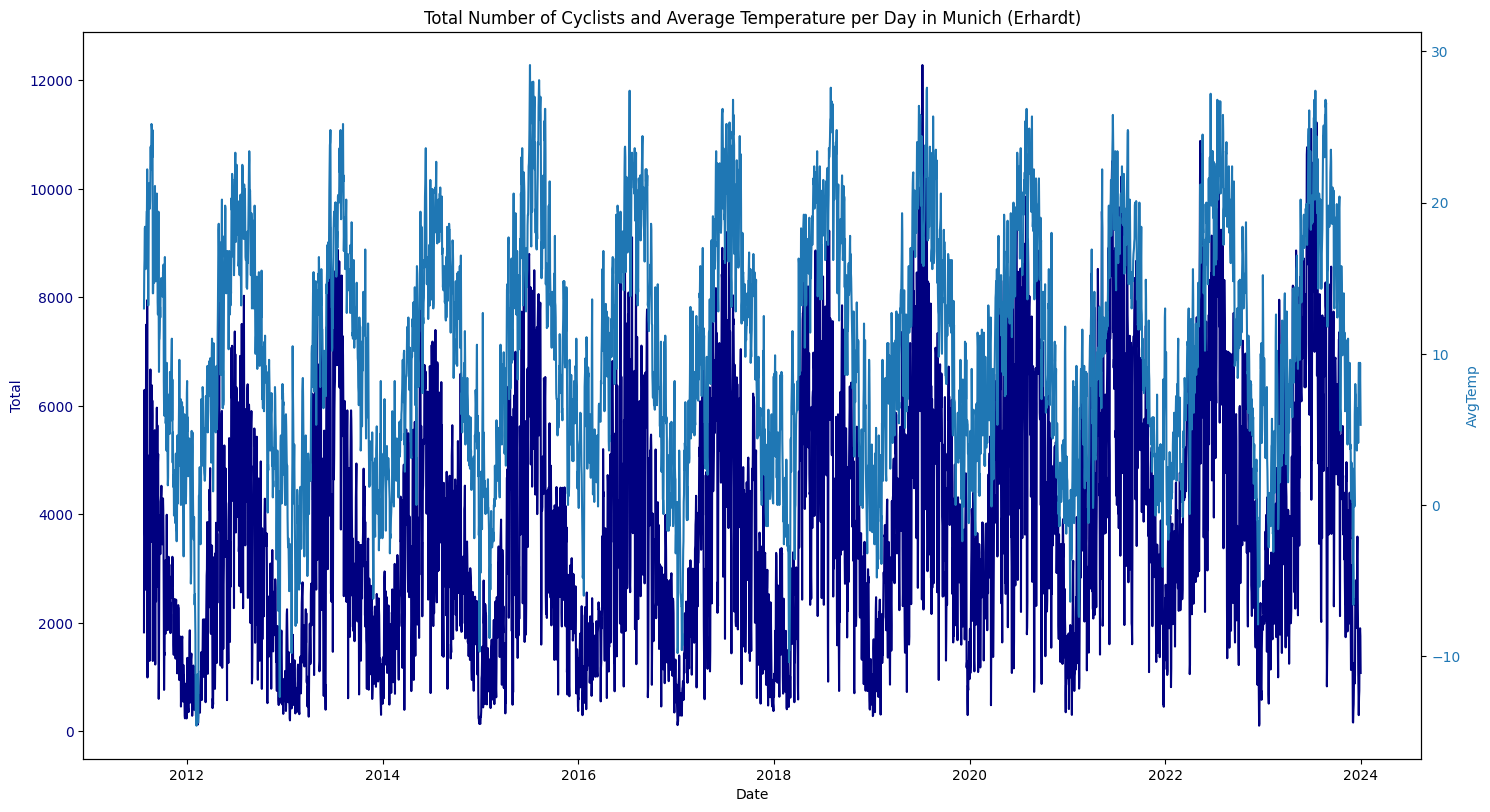

In [10]:
# Plot the total number of cyclists per day and the average temperature per day for the selected location (Erhardt) in Munich
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.set_xlabel('Date')
ax1.set_ylabel('Total', color='navy')
ax1.plot(df_location_erhardt.index, df_location_erhardt['Total'], color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('AvgTemp', color=color)
ax2.plot(df_location_erhardt.index, df_location_erhardt['AvgTemp'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Total Number of Cyclists and Average Temperature per Day in Munich (Erhardt)')
plt.show()


## VAR

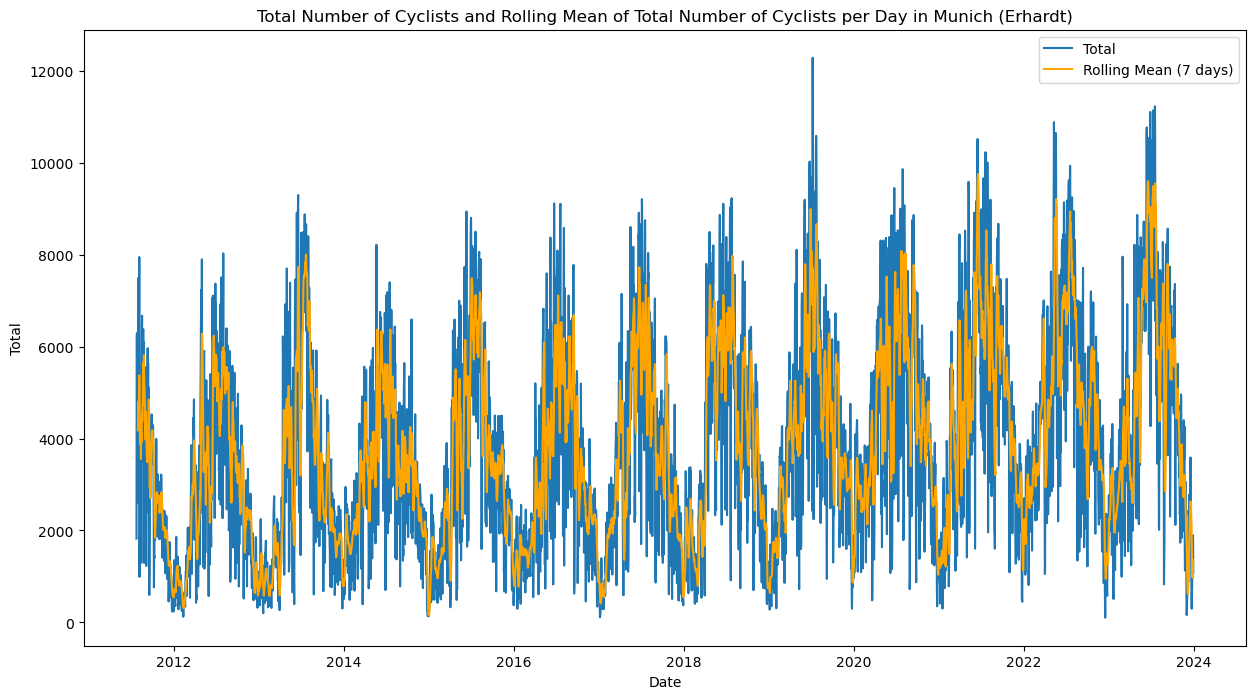

In [160]:
# compare the total number of cyclist and the rolling mean of the total number of cyclists
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_location_erhardt.index, df_location_erhardt['Total'], label='Total')
ax.plot(df_location_erhardt.index, df_location_erhardt['Total'].rolling(window=7).mean(), label='Rolling Mean (7 days)', color='orange')
ax.set_xlabel('Date')
ax.set_ylabel('Total')
ax.legend()
plt.title('Total Number of Cyclists and Rolling Mean of Total Number of Cyclists per Day in Munich (Erhardt)')
plt.show()

In [161]:
# Check stationarity of the time series data using the Augmented Dickey-Fuller test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# Perform the Augmented Dickey-Fuller test on the total number of cyclists per day
adf_test(df_location_erhardt['Total'])


Results of Dickey-Fuller Test:
Test Statistic                   -4.457614
p-value                           0.000234
#Lags Used                       29.000000
Number of Observations Used    4513.000000
Critical Value (1%)              -3.431800
Critical Value (5%)              -2.862181
Critical Value (10%)             -2.567111
dtype: float64


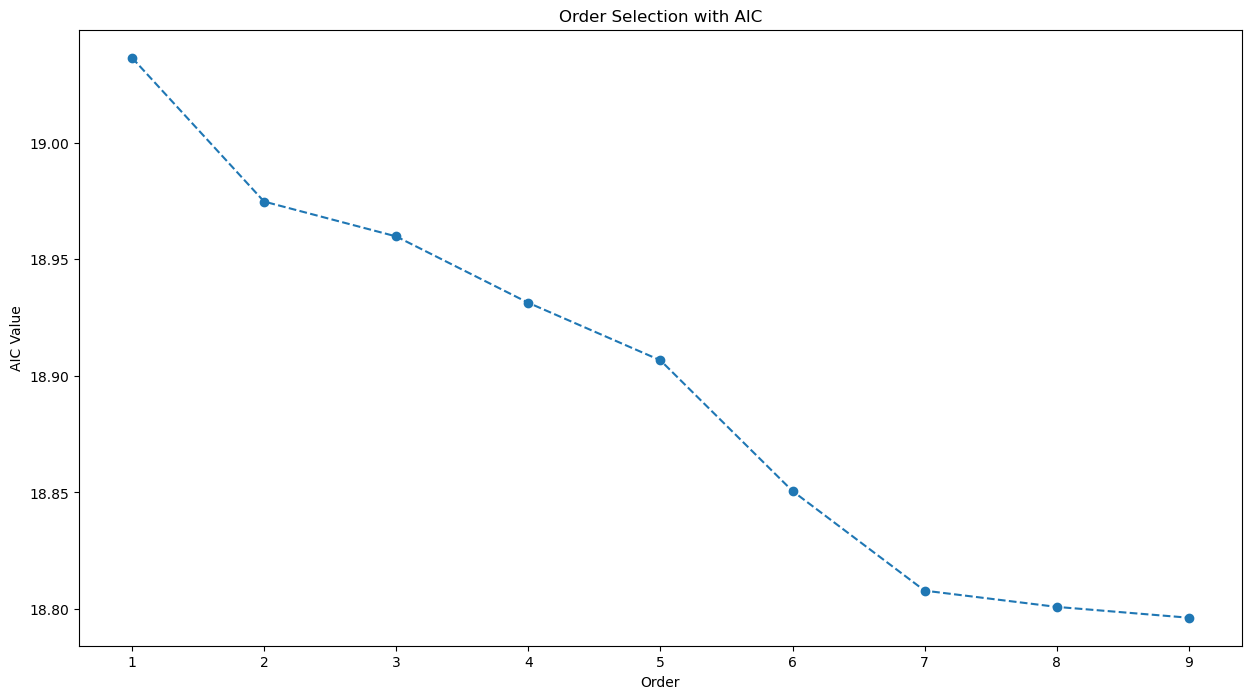

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Mar, 2024
Time:                     10:22:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    18.9152
Nobs:                     4534.00    HQIC:                   18.8382
Log likelihood:          -61827.6    FPE:                1.45590e+08
AIC:                      18.7963    Det(Omega_mle):     1.42926e+08
--------------------------------------------------------------------
Results for equation Total
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                   250.290606        47.645588            5.253           0.000
L1.Total                  0.507447         0.018065           28.091           0.000
L1.AvgTemp               16.153694         8

/Users/caropaez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


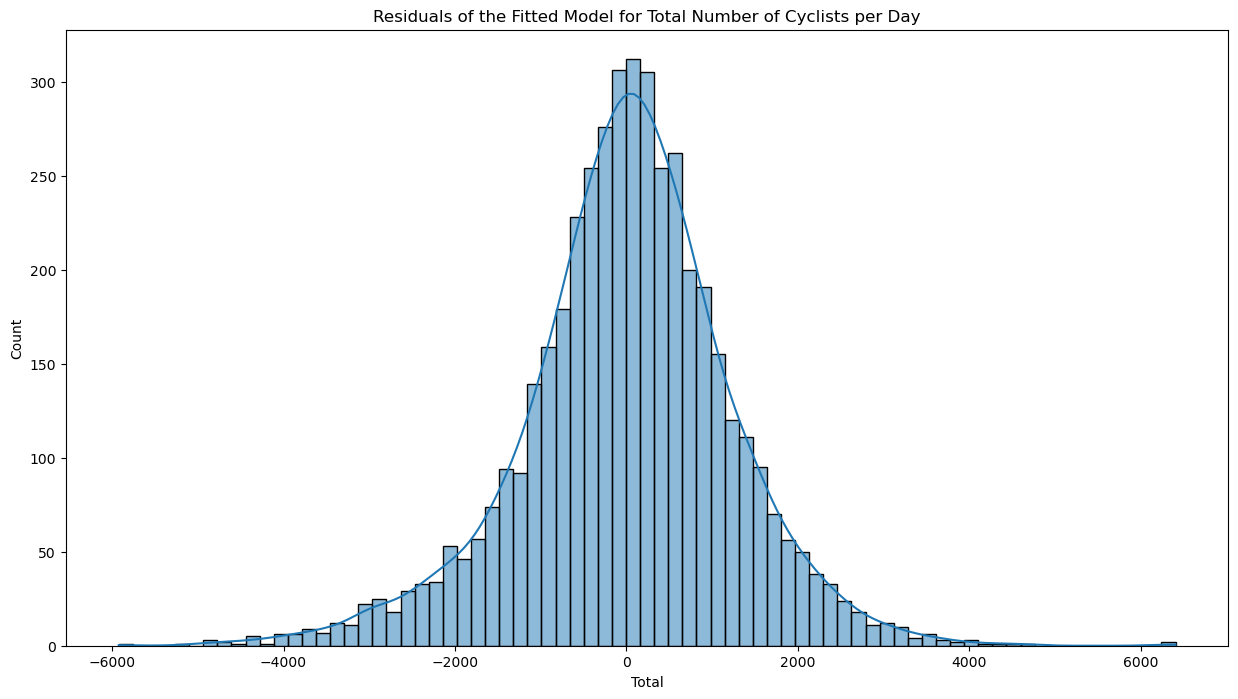

In [162]:
model = VAR(df_location_erhardt[['Total', 'AvgTemp','RainfallVolume']])
aic_vals = []
for i in range(1, 10):
    result = model.fit(i)
    aic_vals.append(result.aic)
optimal_lag = np.argmin(aic_vals) + 1

# visualize the AIC values
plt.figure(figsize=(15, 8))
plt.plot(range(1, 10), aic_vals, marker='o', linestyle='--')
plt.xlabel('Order')
plt.ylabel('AIC Value')
plt.title('Order Selection with AIC')
plt.show()

fitted_model = model.fit(optimal_lag)

# Print the summary of the fitted model
print(fitted_model.summary())

# Model diagnostics
# Check the residuals of the model for normality
residuals = fitted_model.resid
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(residuals['Total'], kde=True, ax=ax)
plt.title('Residuals of the Fitted Model for Total Number of Cyclists per Day')
plt.show()


When adding the RainfallVolume to your VAR model, it appears to significantly affect the residuals of the Total variable. Including RainfallVolume has changed the dynamics of the model, as seen by the coefficients associated with the lagged values of RainfallVolume in predicting Total counts. Notably, the L1.RainfallVolume coefficient is significant and negative, indicating that, as expected, rainfall has an immediate negative effect on bicycle counts.
<br><br>
The AIC (Akaike Information Criterion) value in the model without RainfallVolume was slightly lower (indicating a potentially better fit), but this doesn't necessarily mean the model without RainfallVolume is better overall. It may mean that including RainfallVolume adds complexity without enough added explanatory power for the increase in the number of parameters. However, the model with RainfallVolume provides a more complete picture, as it captures the influence of weather on cycling behavior, which is an important factor.
<br><br>
In the updated model with RainfallVolume, we also see significant coefficients for RainfallVolume at different lags for predicting itself, which makes sense given that weather can have serial correlation (rain one day can be related to rain on previous or subsequent days).
<br><br>
The correlation matrix of residuals shows the relationships between the errors of the equations after accounting for the modeled relationships. Ideally, we'd want these to be close to zero, meaning that the model has accounted for the relationships between the variables effectively, and what's left (the errors) are random noise. However, Total and AvgTemp show a positive correlation, while Total and RainfallVolume have a negative correlation in the residuals, indicating potential relationships that the model hasn't fully captured.
<br><br>
Regarding the high correlation between Total and AvgTemp and the negative correlation between Total and RainfallVolume, these make sense intuitively. More people are likely to cycle on warmer days and less likely to cycle when it rains.
<br><br>
The RMSE values provide a measure of the average magnitude of the forecast errors. A lower RMSE value is better as it indicates closer fits to the actual data. Comparing RMSE values before and after including RainfallVolume can tell you whether including it has improved the predictive accuracy of the model. From the values you've posted, it seems there was a significant improvement in RMSE for the Total variable after including RainfallVolume.

In [163]:
from statsmodels.stats.stattools import durbin_watson

# Fit the VAR model
var_model = VAR(df_location_erhardt[['Total', 'MinTemp', 'MaxTemp', 'RainfallVolume', 'AvgTemp', 'DayOfWeek', 'Month', 'Year']])
var_results = var_model.fit(optimal_lag)

# Get the residuals
residuals = var_results.resid

# Get the Durbin-Watson statistic for each variable
dw_stats = durbin_watson(residuals)

# Match the statistic to each variable name
for var_name, dw_stat in zip(df_location_erhardt.columns, dw_stats):
    print(f'{var_name}: {dw_stat:.2f}')


Total: 2.00
MinTemp: 2.00
MaxTemp: 2.00
RainfallVolume: 2.00
AvgTemp: 2.00
DayOfWeek: 0.35
Month: 2.00
Year: 2.00


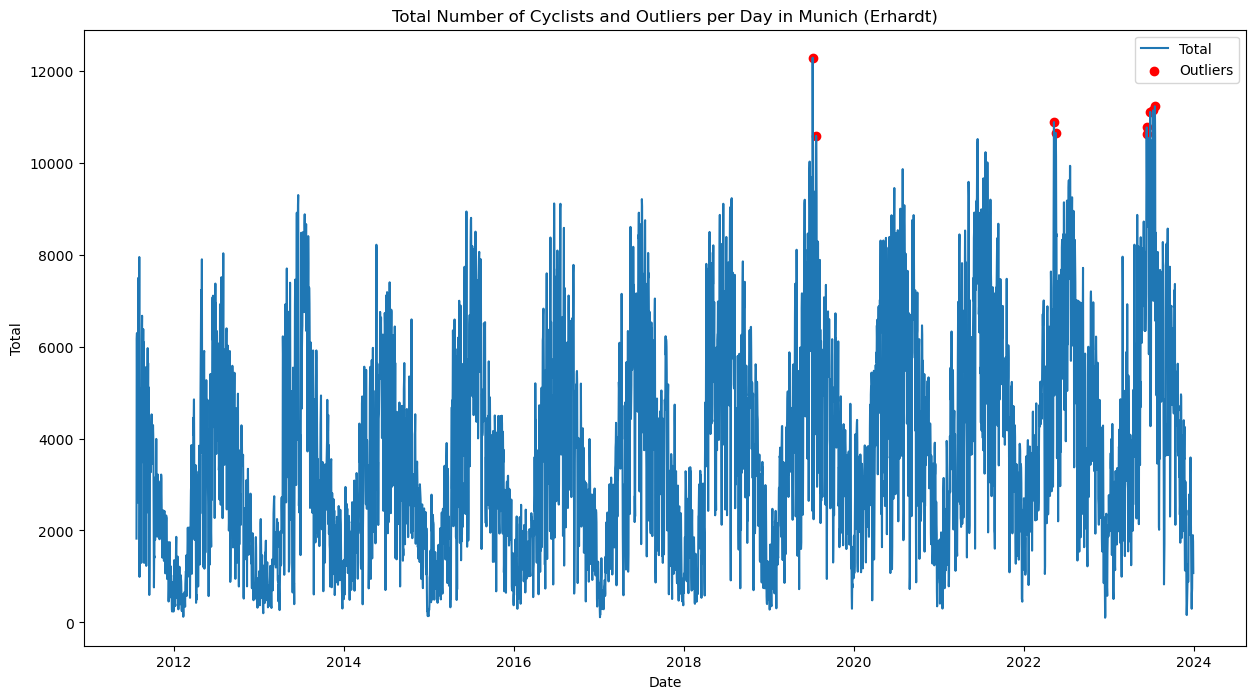

In [164]:

# Z-score method
from scipy import stats


z_scores = np.abs(stats.zscore(df_location_erhardt['Total']))
outliers = np.where(z_scores > 3)

# IQR method
Q1 = df_location_erhardt['Total'].quantile(0.25)
Q3 = df_location_erhardt['Total'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df_location_erhardt['Total'] < (Q1 - 1.5 * IQR)) | (df_location_erhardt['Total'] > (Q3 + 1.5 * IQR))
outliers = df_location_erhardt.loc[outlier_condition]

# Visualize the outliers
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_location_erhardt.index, df_location_erhardt['Total'], label='Total')
ax.scatter(outliers.index, outliers['Total'], color='red', label='Outliers')
ax.set_xlabel('Date')
ax.set_ylabel('Total')
ax.legend()
plt.title('Total Number of Cyclists and Outliers per Day in Munich (Erhardt)')
plt.show()



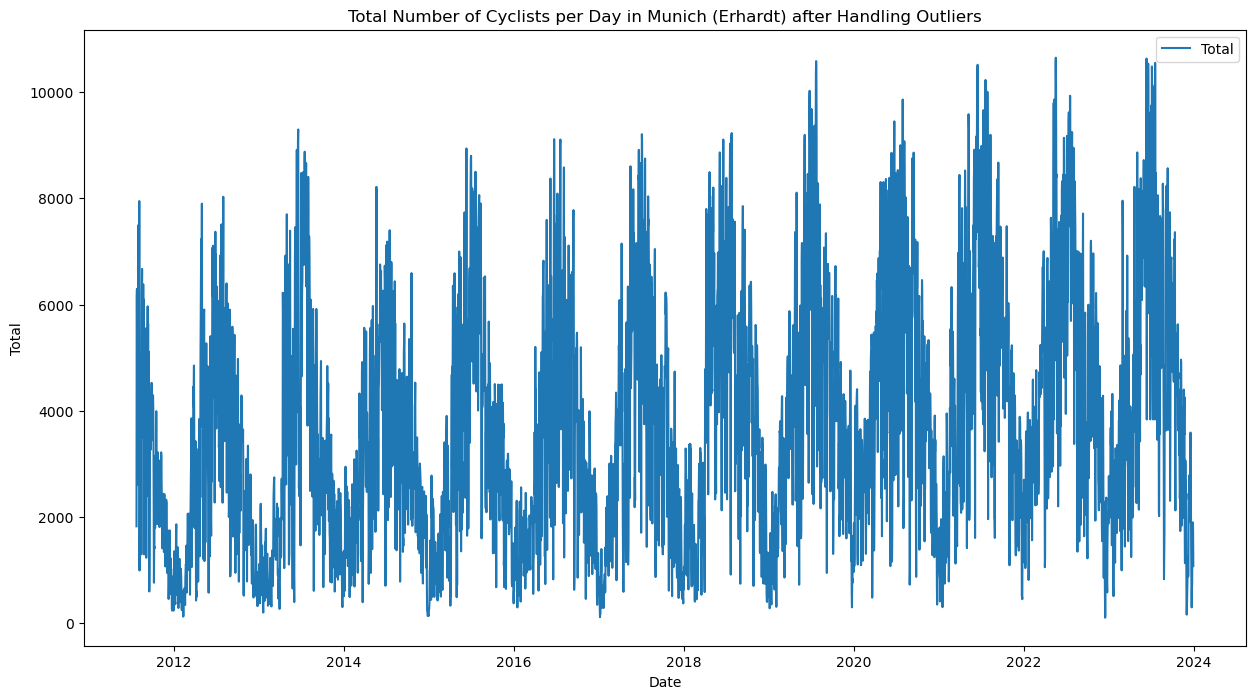

In [165]:
# Handle the outliers by replacing them with the mean of the total number of cyclists per day in the dataset using the z-score method
df_location_erhardt['Total'] = np.where(z_scores > 3, df_location_erhardt['Total'].mean(), df_location_erhardt['Total'])

# Visualize the total number of cyclists per day after handling the outliers
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_location_erhardt.index, df_location_erhardt['Total'], label='Total')
ax.set_xlabel('Date')
ax.set_ylabel('Total')
ax.legend()
plt.title('Total Number of Cyclists per Day in Munich (Erhardt) after Handling Outliers')
plt.show()


In [166]:
# Select only the necessary columns for fitting the VAR model
df_m_e_model = df_location_erhardt
# Fit the VAR model
var_model = VAR(df_m_e_model)
var_results = var_model.fit(maxlags=15, ic=None)

# Find the optimal lag length based on information criteria
lag_order_selection = model.select_order(maxlags=18)
print(lag_order_selection.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        21.92       21.93   3.325e+09       21.93
1        19.03       19.04   1.833e+08       19.03
2        18.96       18.99   1.721e+08       18.97
3        18.95       18.99   1.696e+08       18.96
4        18.93       18.98   1.658e+08       18.95
5        18.90       18.97   1.618e+08       18.93
6        18.85       18.93   1.530e+08       18.87
7        18.80      18.90*   1.465e+08       18.84
8        18.79       18.90   1.454e+08       18.83
9        18.79       18.91   1.447e+08      18.83*
10       18.79       18.92   1.449e+08       18.84
11       18.79       18.94   1.451e+08       18.84
12       18.79       18.95   1.447e+08       18.85
13       18.78       18.95   1.434e+08       18.84
14       18.77       18.95   1.416e+08       18.83
15       18.77       18.96   1.414e+08       18.84
16       18.76       18.97   1.

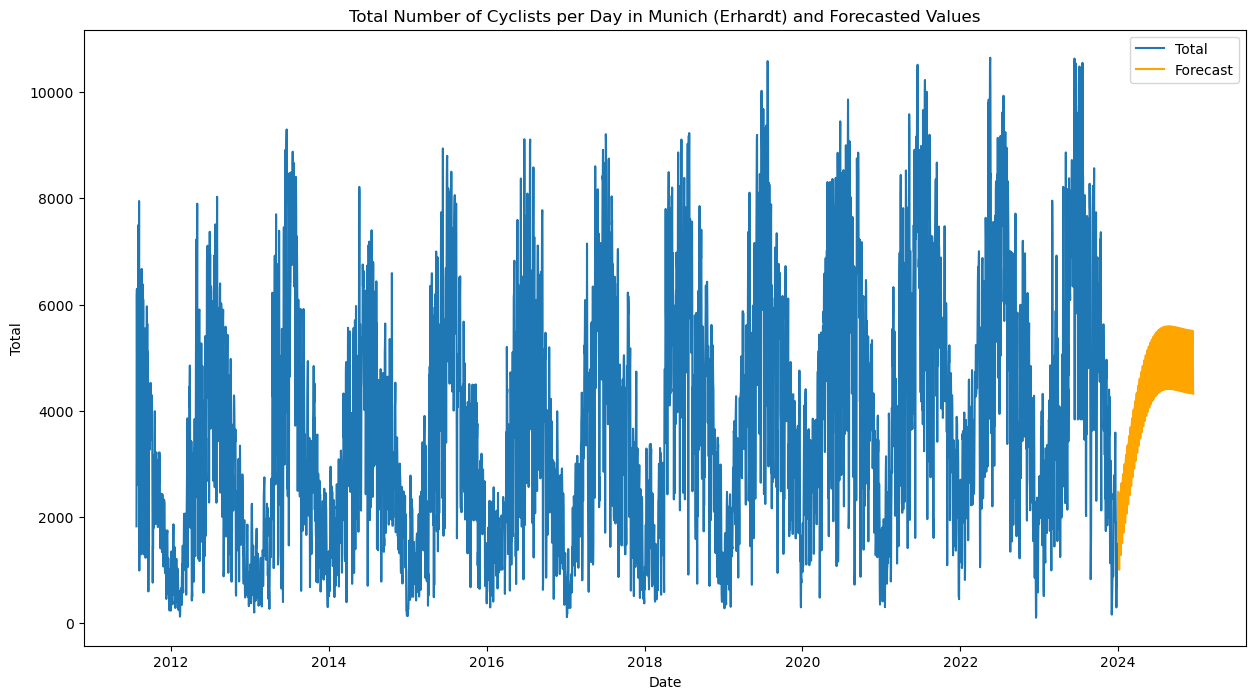

In [167]:
optimal_lag = 15  # Based on the AIC
fitted_model = var_model.fit(optimal_lag)

# To make predictions:
lag_order = fitted_model.k_ar
forecast_input = df_location_erhardt.values[-lag_order:]
forecast_result = fitted_model.forecast(y=forecast_input, steps=350)

# Visualize the forecasted values
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_location_erhardt.index, df_location_erhardt['Total'], label='Total')
ax.plot(pd.date_range(start=df_location_erhardt.index[-1], periods=350), forecast_result[:, 0], label='Forecast', color='orange')
ax.set_xlabel('Date')
ax.set_ylabel('Total')
ax.legend()
plt.title('Total Number of Cyclists per Day in Munich (Erhardt) and Forecasted Values')
plt.show()


In [168]:
from scipy.stats import shapiro

# residuals of the fitted model
residuals = fitted_model.resid

# Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals['Total'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test[0]:.2f}, p-value: {shapiro_test[1]:.2f}')
# Interpret the test result
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Residuals are normally distributed (fail to reject H0)')
else:
    print('Residuals are not normally distributed (reject H0)')
    
# Check for stability of the model
if fitted_model.is_stable():
    print('Model is stable')
else:
    print('Model is not stable')


Shapiro-Wilk Test Statistic: 0.98, p-value: 0.00
Residuals are not normally distributed (reject H0)
Model is not stable


## Neural Networl

In [11]:
# To activate this environment, use
#
#     $ conda activate thesisenv
#
# To deactivate an active environment, use
#
#     $ conda deactivate

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

print("keras version:", keras.__version__)
print("tensorflow version:", tf.__version__)

keras version: 2.15.0
tensorflow version: 2.15.0


Epoch 1/50
45/45 - 1s - loss: 0.1340 - val_loss: 0.1328 - 1s/epoch - 30ms/step
Epoch 2/50
45/45 - 0s - loss: 0.1067 - val_loss: 0.1302 - 68ms/epoch - 2ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0953 - val_loss: 0.1161 - 67ms/epoch - 1ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0882 - val_loss: 0.1069 - 66ms/epoch - 1ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0828 - val_loss: 0.1004 - 66ms/epoch - 1ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0797 - val_loss: 0.0968 - 65ms/epoch - 1ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0781 - val_loss: 0.0951 - 67ms/epoch - 1ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0772 - val_loss: 0.0945 - 68ms/epoch - 2ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0768 - val_loss: 0.0943 - 68ms/epoch - 2ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0762 - val_loss: 0.0943 - 68ms/epoch - 2ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0760 - val_loss: 0.0942 - 67ms/epoch - 1ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0758 - val_loss: 0.0940 - 67ms/epoch - 1ms/step
Epoch 13/50
45/45 - 0s - loss: 0.0757 

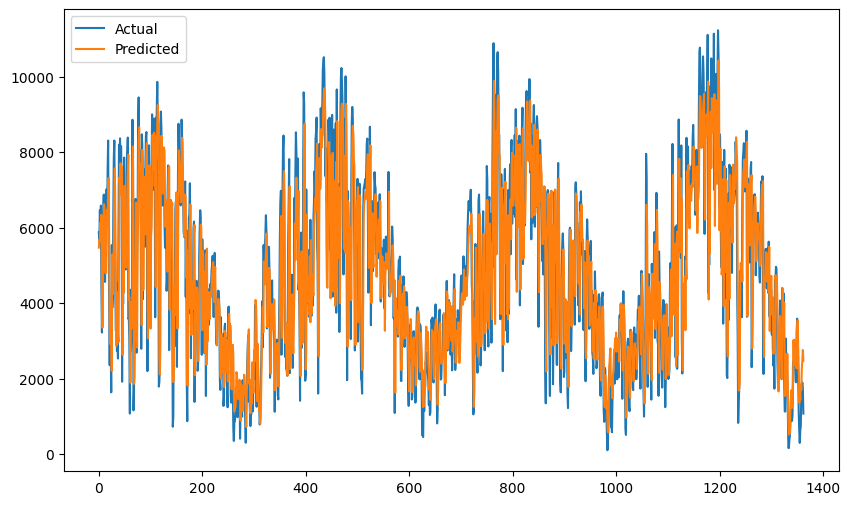

In [14]:
# Assuming df_location_erhardt is your DataFrame and is already loaded
# Ensure the DataFrame only contains the columns you're interested in
df = df_location_erhardt[['Total', 'MinTemp', 'MaxTemp', 'RainfallVolume']]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Specify the number of lag hours
n_hours = 1
n_features = 4
# Frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# Split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit model
model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)  # Adjust based on the number of features used
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)  # Adjust based on the number of features used
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(inv_y, label='Actual')
plt.plot(inv_yhat, label='Predicted')
plt.legend()
plt.show()
